# Final Project: Twitter Sentiment Analysis
## By Tharun Prabhakar, Sumit Kumar, Niranjan Kumar Kishore Kumar

In [1]:
import pandas as pd
import numpy as np
# import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
import seaborn as sns
from warnings import filterwarnings
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
from yellowbrick.classifier import ROCAUC

In [2]:
filterwarnings('ignore')
sns.set(style="whitegrid")
# nlp = spacy.load('en_core_web_lg')

In [3]:
df = pd.read_csv('twitter_training.csv')
df.head()

,Tweeet_Id,Company,Label,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
df_validation = pd.read_csv('twitter_validation.csv')
df_validation.head()

,Tweet_Id,Company,Label,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [5]:
df.shape,df_validation.shape

((74682, 4), (1000, 4))

In [6]:
df.dtypes

Tweeet_Id     int64
Company      object
Label        object
Tweet        object
dtype: object

In [7]:
df.describe(exclude=np.number)

,Company,Label,Tweet
count,74682,74682,73996
unique,32,4,69491
top,TomClancysRainbowSix,Negative,"At the same time, despite the fact that there ..."
freq,2400,22542,172


In [8]:
total=df.isnull().sum().sort_values(ascending=False) # Total Number of Null Values
percent=(df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False) # Calculating the percentage of missing values
missed=pd.concat([total,percent],axis=1,keys=['total','percent'])
missed

,total,percent
Tweet,686,0.918561
Tweeet_Id,0,0.000000
Company,0,0.000000
Label,0,0.000000


In [9]:
total=df_validation.isnull().sum().sort_values(ascending=False) # Total Number of Null Values
percent=(df_validation.isnull().sum()/df_validation.isnull().count()*100).sort_values(ascending=False) # Calculating the percentage of missing values
missed=pd.concat([total,percent],axis=1,keys=['total','percent'])
missed

,total,percent
Tweet_Id,0,0.0
Company,0,0.0
Label,0,0.0
Tweet,0,0.0


In [10]:
df.dropna(inplace = True)
df_validation.dropna(inplace = True)

In [11]:
total=df.isnull().sum().sort_values(ascending=False) # Total Number of Null Values
percent=(df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False) # Calculating the percentage of missing values
missed=pd.concat([total,percent],axis=1,keys=['total','percent'])
missed

,total,percent
Tweeet_Id,0,0.0
Company,0,0.0
Label,0,0.0
Tweet,0,0.0


In [12]:
df.shape

(73996, 4)

In [13]:
df.Company.value_counts()

Company
MaddenNFL                            2377
LeagueOfLegends                      2377
CallOfDuty                           2376
Verizon                              2365
TomClancysRainbowSix                 2364
Facebook                             2362
Microsoft                            2361
Dota2                                2359
WorldOfCraft                         2357
ApexLegends                          2353
NBA2K                                2343
CallOfDutyBlackopsColdWar            2343
FIFA                                 2324
johnson&johnson                      2324
TomClancysGhostRecon                 2321
Battlefield                          2316
Overwatch                            2316
GrandTheftAuto(GTA)                  2293
HomeDepot                            2292
PlayStation5(PS5)                    2291
Hearthstone                          2286
CS-GO                                2284
Xbox(Xseries)                        2283
Borderlands               

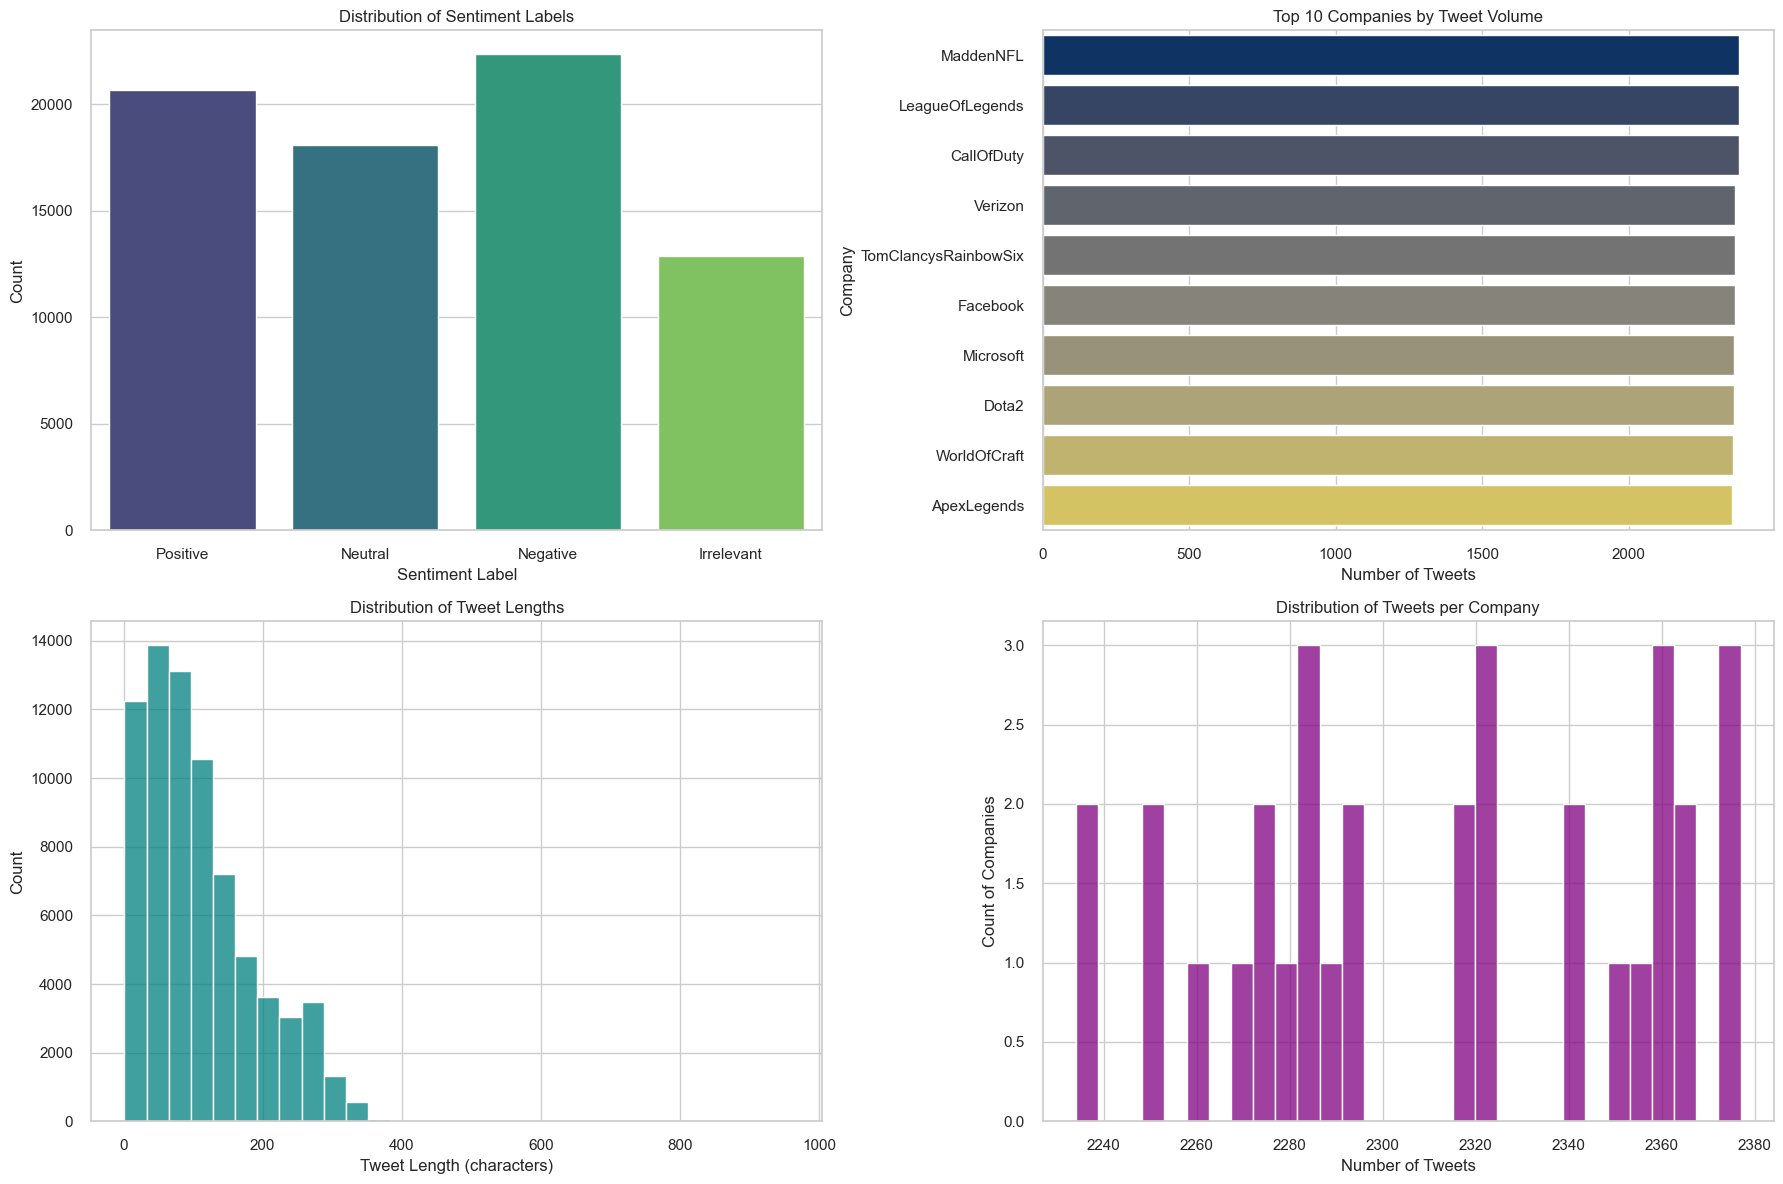

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot for distribution of labels (sentiments)
sns.countplot(x='Label', data=df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribution of Sentiment Labels')
axes[0, 0].set_xlabel('Sentiment Label')
axes[0, 0].set_ylabel('Count')

# Plot for the top 10 companies mentioned in tweets
top_companies = df['Company'].value_counts().nlargest(10)
sns.barplot(x=top_companies.values, y=top_companies.index, ax=axes[0, 1], palette='cividis')
axes[0, 1].set_title('Top 10 Companies by Tweet Volume')
axes[0, 1].set_xlabel('Number of Tweets')
axes[0, 1].set_ylabel('Company')

# Plot for tweet length distribution
tweet_lengths = df['Tweet'].dropna().apply(len)
sns.histplot(tweet_lengths, bins=30, ax=axes[1, 0], color='teal')
axes[1, 0].set_title('Distribution of Tweet Lengths')
axes[1, 0].set_xlabel('Tweet Length (characters)')
axes[1, 0].set_ylabel('Count')

# Plot for number of tweets per company
tweets_per_company = df['Company'].value_counts()
sns.histplot(tweets_per_company, bins=30, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Distribution of Tweets per Company')
axes[1, 1].set_xlabel('Number of Tweets')
axes[1, 1].set_ylabel('Count of Companies')

plt.tight_layout()
plt.show()

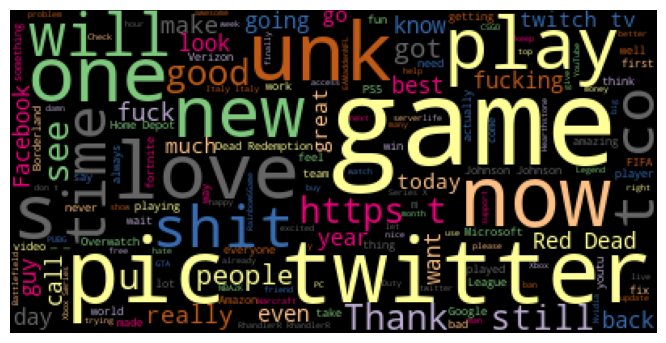

In [16]:
all_text = " ".join(df.Tweet)

wc = WordCloud(stopwords = STOPWORDS, colormap = "Accent").generate(all_text)

plt.figure(figsize = (9,4.2))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [17]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs, hashtags, mentions, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words to reconstruct the text
    text = ' '.join(words)
    return text

df['pre_processed'] = df.Tweet.apply(lambda x : preprocess_text(x))
df_validation['pre_processed'] = df_validation.Tweet.apply(lambda x : preprocess_text(x))

In [110]:
df_validation

,Tweet_Id,Company,Label,Tweet,pre_processed
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,mentioned facebook struggling motivation go ru...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon bos jeff bezos reject claim co...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,pay word function poorly chromebook
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...
4,4433,Google,Neutral,Now the President is slapping Americans in the...,president slapping american face really commit...
...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,toronto art culture capital canada wonder want...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,actually good move tot bring viewer one people...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,today sucked time drink wine n play borderland...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,bought fraction microsoft today small win


In [20]:
X = df['pre_processed'] 
y = df['Label']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model with TFIDF Vectorizer

In [96]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', None), 
]) 

### Test

Model: DecisionTreeClassifier()
              precision    recall  f1-score   support

  Irrelevant       0.77      0.68      0.72      2696
    Negative       0.81      0.81      0.81      4380
     Neutral       0.80      0.74      0.77      3605
    Positive       0.73      0.83      0.78      4119

    accuracy                           0.78     14800
   macro avg       0.78      0.77      0.77     14800
weighted avg       0.78      0.78      0.78     14800

[[1824  255  212  405]
 [ 188 3551  218  423]
 [ 173  325 2681  426]
 [ 182  276  226 3435]]



Model: RandomForestClassifier()
              precision    recall  f1-score   support

  Irrelevant       0.95      0.81      0.87      2696
    Negative       0.91      0.93      0.92      4380
     Neutral       0.91      0.86      0.89      3605
    Positive       0.83      0.94      0.88      4119

    accuracy                           0.89     14800
   macro avg       0.90      0.88      0.89     14800
weighted avg       0.90  

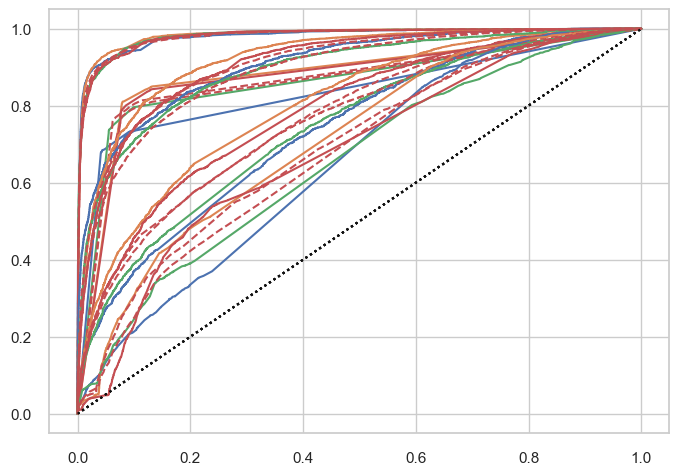

In [102]:
model = [DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(),MultinomialNB()]
model_names = [ 'DecisionTreeClassifier_TF', 'RandomForestClassifier_TF', 'GradientBoostingClassifier_TF', 'AdaBoostClassifier_TF', 'MultinomialNB_TF']
results = {
    'Model': [],
    'Misclassifications': [],
    'Type I Error': [],
    'Type II Error': [],
    'Precision': [],
    'Recall': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'F1 Score': [],
    'AUC Score': []
}
model_dict = dict(zip(model, model_names))
for i in model:
    pipeline.set_params(classifier = i)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    misclassification = len(y_test) - np.sum(y_test == y_pred)
    type1_error = confusion_matrix(y_test, y_pred)[0,1]
    type2_error = confusion_matrix(y_test, y_pred)[1,0]
    
    # Calculate AUC score
    visualizer = ROCAUC(pipeline, classes=['Irrelevant','Negative','Neutral','Positive'])
    visualizer.fit(X_train, y_train)
    auc_score = visualizer.score(X_test, y_test)
    
    results['AUC Score'].append(auc_score)
    results['Model'].append(model_dict[i])
    results['Train Accuracy'].append(train_accuracy)
    results['Test Accuracy'].append(test_accuracy)
    results['F1 Score'].append(f1)
    results['Precision'].append(precision)
    results['Misclassifications'].append(misclassification)
    results['Type I Error'].append(type1_error)
    results['Type II Error'].append(type2_error)
    results['Recall'].append(recall)
    
    print(f"Model: {i}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n\n") 
    
    
TV_results = pd.DataFrame(results)


In [103]:
TV_results

,Model,Misclassifications,Type I Error,Type II Error,Precision,Recall,Train Accuracy,Test Accuracy,F1 Score,AUC Score
0,DecisionTreeClassifier_TF,3309,255,188,0.778414,0.776419,0.972768,0.776419,0.775664,0.863111
1,RandomForestClassifier_TF,1594,155,30,0.896222,0.892297,0.972768,0.892297,0.892120,0.981953
2,GradientBoostingClassifier_TF,7212,1441,59,0.563657,0.512703,0.539580,0.512703,0.482690,0.767097
3,AdaBoostClassifier_TF,8138,1609,117,0.482551,0.450135,0.463342,0.450135,0.414390,0.674452
4,MultinomialNB_TF,4592,853,15,0.739111,0.689730,0.758599,0.689730,0.673476,0.909636


### Validation

Model: DecisionTreeClassifier()
Train_Accuracy: 0.9723498567490134
Test_Accuracy: 0.916
              precision    recall  f1-score   support

  Irrelevant       0.88      0.92      0.90       172
    Negative       0.92      0.94      0.93       266
     Neutral       0.93      0.91      0.92       285
    Positive       0.91      0.90      0.91       277

    accuracy                           0.92      1000
   macro avg       0.91      0.92      0.91      1000
weighted avg       0.92      0.92      0.92      1000

[[158   3   4   7]
 [  6 250   3   7]
 [  9   8 258  10]
 [  6  10  11 250]]



Model: RandomForestClassifier()
Train_Accuracy: 0.9723498567490134
Test_Accuracy: 0.973
              precision    recall  f1-score   support

  Irrelevant       0.98      0.96      0.97       172
    Negative       0.97      0.98      0.97       266
     Neutral       0.98      0.97      0.98       285
    Positive       0.96      0.98      0.97       277

    accuracy                         

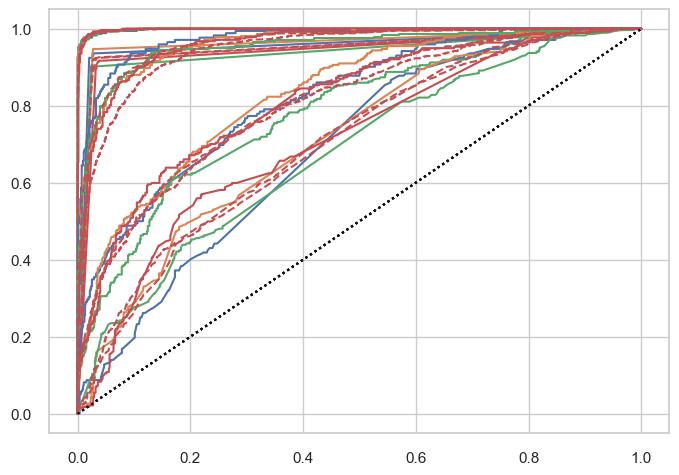

In [116]:
model_names_validation = ['DecisionTreeClassifier_TF_VAL', 'RandomForestClassifier_TF_VAL', 'GradientBoostingClassifier_TF_VAL', 'AdaBoostClassifier_TF_VAL', 'MultinomialNB_TF_VAL']
results_tf_val = {
    'Model': [],
    'Misclassifications': [],
    'Type I Error': [],
    'Type II Error': [],
    'Precision': [],
    'Recall': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'F1 Score': [],
    'AUC Score': []
}
model_dict_validation = dict(zip(model, model_names_validation))
for i in model:
    pipeline.set_params(classifier = i)
    pipeline.fit(X, y)
    y_pred = pipeline.predict(df_validation['pre_processed'])
    train_accuracy = accuracy_score(y, pipeline.predict(X))
    test_accuracy = accuracy_score(df_validation['Label'], y_pred)
    f1 = f1_score(df_validation['Label'], y_pred, average='weighted')
    precision = precision_score(df_validation['Label'], y_pred, average='weighted')
    recall = recall_score(df_validation['Label'], y_pred, average='weighted')
    
    misclassification = len(df_validation['Label']) - np.sum(df_validation['Label'] == y_pred)
    type1_error = confusion_matrix(df_validation['Label'], y_pred)[0,1]
    type2_error = confusion_matrix(df_validation['Label'], y_pred)[1,0]
    # Calculate AUC score
    visualizer = ROCAUC(pipeline, classes=['Irrelevant','Negative','Neutral','Positive'])
    visualizer.fit(X, y)
    auc_score = visualizer.score(df_validation['pre_processed'], df_validation['Label'])
    
   
    results_tf_val['Model'].append(model_dict_validation[i])
    results_tf_val['Train Accuracy'].append(train_accuracy)
    results_tf_val['Test Accuracy'].append(test_accuracy)
    results_tf_val['F1 Score'].append(f1)
    results_tf_val['Precision'].append(precision)
    results_tf_val['Misclassifications'].append(misclassification)
    results_tf_val['Type I Error'].append(type1_error)
    results_tf_val['Type II Error'].append(type2_error)
    results_tf_val['Recall'].append(recall)
    results_tf_val['AUC Score'].append(auc_score)
    
    print(f"Model: {i}")
    print(f"Train_Accuracy:",train_accuracy)
    print(f"Test_Accuracy:",test_accuracy)
    print(classification_report(df_validation['Label'], y_pred))
    print(confusion_matrix(df_validation['Label'], y_pred))
   
    
    print("\n\n")
    
TV_results_Validation = pd.DataFrame(results_tf_val)

In [117]:
TV_results_Validation

,Model,Misclassifications,Type I Error,Type II Error,Precision,Recall,Train Accuracy,Test Accuracy,F1 Score,AUC Score
0,DecisionTreeClassifier_TF_VAL,84,3,6,0.916359,0.916,0.972350,0.916,0.916021,0.949275
1,RandomForestClassifier_TF_VAL,27,2,2,0.973130,0.973,0.972350,0.973,0.973009,0.998491
2,GradientBoostingClassifier_TF_VAL,452,72,5,0.606434,0.548,0.537610,0.548,0.535587,0.811862
3,AdaBoostClassifier_TF_VAL,552,99,5,0.507183,0.448,0.459241,0.448,0.413292,0.696526
4,MultinomialNB_TF_VAL,214,38,1,0.819854,0.786,0.766636,0.786,0.782372,0.963299


### Model with countvectorizer

In [111]:
pipeline_cv = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', None)
])

### Test

Model: DecisionTreeClassifier()
Train_Accuracy: 0.9728360024325968
Test_Accuracy: 0.8031756756756757
              precision    recall  f1-score   support

  Irrelevant       0.81      0.73      0.76      2696
    Negative       0.84      0.83      0.84      4380
     Neutral       0.83      0.77      0.80      3605
    Positive       0.75      0.85      0.80      4119

    accuracy                           0.80     14800
   macro avg       0.81      0.79      0.80     14800
weighted avg       0.81      0.80      0.80     14800

[[1956  224  166  350]
 [ 137 3653  207  383]
 [ 164  249 2764  428]
 [ 170  236  199 3514]]



Model: RandomForestClassifier()
Train_Accuracy: 0.9728360024325968
Test_Accuracy: 0.8908108108108108
              precision    recall  f1-score   support

  Irrelevant       0.94      0.82      0.88      2696
    Negative       0.91      0.92      0.91      4380
     Neutral       0.92      0.85      0.89      3605
    Positive       0.83      0.94      0.88      4

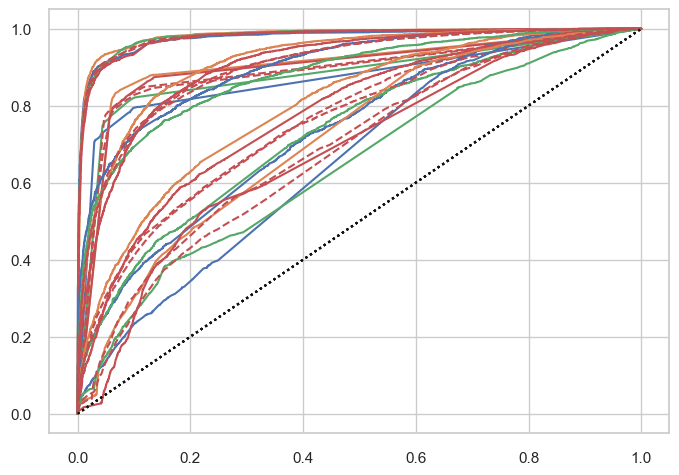

In [118]:
model = [DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(),MultinomialNB()]
model_names = ['DecisionTreeClassifier_CV', 'RandomForestClassifier_CV', 'GradientBoostingClassifier_CV', 'AdaBoostClassifier_CV', 'MultinomialNB_CV']
results_CV = {
    'Model': [],
    'Misclassifications': [],
    'Type I Error': [],
    'Type II Error': [],
    'Precision': [],
    'Recall': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'F1 Score': [],
    'AUC Score': []
}

model_dict = dict(zip(model, model_names))

for i in model:
    pipeline_cv.set_params(classifier = i)
    pipeline_cv.fit(X_train, y_train)
    y_pred = pipeline_cv.predict(X_test)
    train_accuracy = accuracy_score(y_train, pipeline_cv.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    misclassification = len(y_test) - np.sum(y_test == y_pred)
    type1_error = confusion_matrix(y_test, y_pred)[0,1]
    type2_error = confusion_matrix(y_test, y_pred)[1,0]
    
     # Calculate AUC score
    visualizer = ROCAUC(pipeline_cv, classes=['Irrelevant','Negative','Neutral','Positive'])
    visualizer.fit(X_train, y_train)
    auc_score = visualizer.score(X_test, y_test)
    
    results_CV['AUC Score'].append(auc_score)
    results_CV['Model'].append(model_dict[i])
    results_CV['Train Accuracy'].append(train_accuracy)
    results_CV['Test Accuracy'].append(test_accuracy)
    results_CV['F1 Score'].append(f1)
    results_CV['Precision'].append(precision)
    results_CV['Misclassifications'].append(misclassification)
    results_CV['Type I Error'].append(type1_error)
    results_CV['Type II Error'].append(type2_error)
    results_CV['Recall'].append(recall)
    
    print(f"Model: {i}")
    print(f"Train_Accuracy:",train_accuracy)
    print(f"Test_Accuracy:",test_accuracy)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n\n") 
    
CV_results = pd.DataFrame(results_CV)

In [119]:
CV_results

,Model,Misclassifications,Type I Error,Type II Error,Precision,Recall,Train Accuracy,Test Accuracy,F1 Score,AUC Score
0,DecisionTreeClassifier_CV,2913,224,137,0.805664,0.803176,0.972836,0.803176,0.802850,0.887496
1,RandomForestClassifier_CV,1616,146,29,0.895096,0.890811,0.972836,0.890811,0.890761,0.979895
2,GradientBoostingClassifier_CV,7272,1419,38,0.568783,0.508649,0.529850,0.508649,0.475960,0.760068
3,AdaBoostClassifier_CV,8146,1610,61,0.478516,0.449595,0.461551,0.449595,0.407857,0.675270
4,MultinomialNB_CV,4203,540,97,0.730795,0.716014,0.778786,0.716014,0.711487,0.902420


#### Validation

Model: DecisionTreeClassifier()
              precision    recall  f1-score   support

  Irrelevant       0.90      0.93      0.92       172
    Negative       0.95      0.95      0.95       266
     Neutral       0.95      0.93      0.94       285
    Positive       0.94      0.94      0.94       277

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

[[160   2   4   6]
 [  6 253   4   3]
 [  5   8 264   8]
 [  6   4   6 261]]



Model: RandomForestClassifier()
              precision    recall  f1-score   support

  Irrelevant       0.98      0.95      0.96       172
    Negative       0.97      0.97      0.97       266
     Neutral       0.98      0.95      0.97       285
    Positive       0.94      0.99      0.96       277

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.

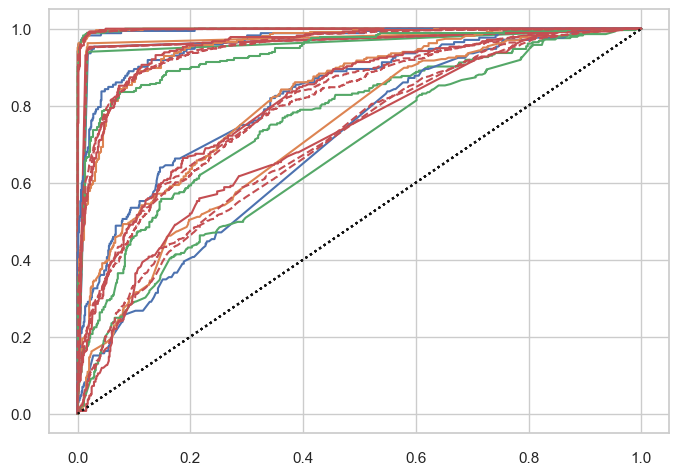

In [127]:
model_names_validation = ['DecisionTreeClassifier_CV_VAL', 'RandomForestClassifier_CV_VAL', 'GradientBoostingClassifier_CV_VAL', 'AdaBoostClassifier_CV_VAL', 'MultinomialNB_CV_VAL']
results_CV_val= {
    'Model': [],
    'Misclassifications': [],
    'Type I Error': [],
    'Type II Error': [],
    'Precision': [],
    'Recall': [],
    'Train Accuracy': [],
    'Test Accuracy': [],
    'F1 Score': [],
    'AUC Score': []
}
model_dict_validation = dict(zip(model, model_names_validation))
for i in model:
    pipeline_cv.set_params(classifier = i)
    pipeline_cv.fit(X, y)
    y_pred = pipeline_cv.predict(df_validation['pre_processed'])
    train_accuracy = accuracy_score(y, pipeline_cv.predict(X))
    test_accuracy = accuracy_score(df_validation['Label'], y_pred)
    f1 = f1_score(df_validation['Label'], y_pred, average='weighted')
    precision = precision_score(df_validation['Label'], y_pred, average='weighted')
    recall = recall_score(df_validation['Label'], y_pred, average='weighted')
     # Calculate AUC score
    visualizer = ROCAUC(pipeline_cv, classes=['Irrelevant','Negative','Neutral','Positive'])
    visualizer.fit(X, y)
    auc_score = visualizer.score(df_validation['pre_processed'], df_validation['Label'])
    
    
    misclassification = len(df_validation['Label']) - np.sum(df_validation['Label'] == y_pred)
    type1_error = confusion_matrix(df_validation['Label'], y_pred)[0,1]
    type2_error = confusion_matrix(df_validation['Label'], y_pred)[1,0]
    
    results_CV_val['Model'].append(model_dict_validation[i])
    results_CV_val['Train Accuracy'].append(train_accuracy)
    results_CV_val['Test Accuracy'].append(test_accuracy)
    results_CV_val['F1 Score'].append(f1)
    results_CV_val['Precision'].append(precision)
    results_CV_val['Misclassifications'].append(misclassification)
    results_CV_val['Type I Error'].append(type1_error)
    results_CV_val['Type II Error'].append(type2_error)
    results_CV_val['Recall'].append(recall)
    results_CV_val['AUC Score'].append(auc_score)
    

    print(f"Model: {i}")
    print(classification_report(df_validation['Label'], y_pred))
    print(confusion_matrix(df_validation['Label'], y_pred))
    print("\n\n")


cv_results_validation= pd.DataFrame(results_CV_val)

In [128]:
cv_results_validation

,Model,Misclassifications,Type I Error,Type II Error,Precision,Recall,Train Accuracy,Test Accuracy,F1 Score,AUC Score
0,DecisionTreeClassifier_CV_VAL,62,2,6,0.938241,0.938,0.972431,0.938,0.938045,0.967574
1,RandomForestClassifier_CV_VAL,33,2,2,0.967430,0.967,0.972417,0.967,0.967002,0.998607
2,GradientBoostingClassifier_CV_VAL,452,78,5,0.607585,0.548,0.527731,0.548,0.531828,0.809108
3,AdaBoostClassifier_CV_VAL,554,92,7,0.478234,0.446,0.454930,0.446,0.414975,0.701924
4,MultinomialNB_CV_VAL,194,25,3,0.818635,0.806,0.781083,0.806,0.805000,0.954337


In [131]:
final_result = pd.concat([TV_results,TV_results_Validation,CV_results,cv_results_validation],axis=0,ignore_index=True)
final_result

,Model,Misclassifications,Type I Error,Type II Error,Precision,Recall,Train Accuracy,Test Accuracy,F1 Score,AUC Score
0,DecisionTreeClassifier_TF,3309,255,188,0.778414,0.776419,0.972768,0.776419,0.775664,0.863111
1,RandomForestClassifier_TF,1594,155,30,0.896222,0.892297,0.972768,0.892297,0.892120,0.981953
2,GradientBoostingClassifier_TF,7212,1441,59,0.563657,0.512703,0.539580,0.512703,0.482690,0.767097
3,AdaBoostClassifier_TF,8138,1609,117,0.482551,0.450135,0.463342,0.450135,0.414390,0.674452
4,MultinomialNB_TF,4592,853,15,0.739111,0.689730,0.758599,0.689730,0.673476,0.909636
5,DecisionTreeClassifier_TF_VAL,84,3,6,0.916359,0.916000,0.972350,0.916000,0.916021,0.949275
6,RandomForestClassifier_TF_VAL,27,2,2,0.973130,0.973000,0.972350,0.973000,0.973009,0.998491
7,GradientBoostingClassifier_TF_VAL,452,72,5,0.606434,0.548000,0.537610,0.548000,0.535587,0.811862
8,AdaBoostClassifier_TF_VAL,552,99,5,0.507183,0.448000,0.459241,0.448000,0.413292,0.696526
9,MultinomialNB_TF_VAL,214,38,1,0.819854,0.786000,0.766636,0.786000,0.782372,0.963299
